In [5]:
# Check Python, Torch, and GPU
import platform, torch
print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Optional: show GPU
!nvidia-smi -L || true
!nvidia-smi || true

# Speed knob for ConvNets on fixed input size
torch.backends.cudnn.benchmark = True

# Core installs (quiet)
!pip -q install --upgrade pip
!pip -q install timm==1.0.9 albumentations==1.4.4 kagglehub==0.3.3 grad-cam==1.5.4

Python: 3.12.12
Torch: 2.8.0+cu126
CUDA available: True
GPU 0: Tesla T4 (UUID: GPU-c967c181-62de-692c-72ba-a88a29f105b3)
Sun Nov  9 21:08:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                  

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJ = "/content/plant_disease"
os.makedirs(PROJ, exist_ok=True)
OUT_DIR = f"{PROJ}/outputs"; os.makedirs(OUT_DIR, exist_ok=True)
CKPT_DIR = "/content/drive/MyDrive/plant_disease_ckpts"; os.makedirs(CKPT_DIR, exist_ok=True)
print("OUT_DIR:", OUT_DIR)
print("CKPT_DIR (Drive):", CKPT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OUT_DIR: /content/plant_disease/outputs
CKPT_DIR (Drive): /content/drive/MyDrive/plant_disease_ckpts


In [7]:
import kagglehub, os, glob, shutil, random
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

# Download dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

# Helper to find split folders (train/val/test)
def find_split_dirs(root: str):
    rootp = Path(root)
    candidates = []
    for p in rootp.rglob("*"):
        if p.is_dir() and p.name.lower() in {"train","valid","val","test"}:
            candidates.append(p)
    split_map = {"train": None, "val": None, "valid": None, "test": None}
    for c in candidates:
        n = c.name.lower()
        if n == "train": split_map["train"] = str(c)
        elif n == "val": split_map["val"] = str(c)
        elif n == "valid": split_map["valid"] = str(c)
        elif n == "test": split_map["test"] = str(c)
    if split_map["val"] is None and split_map["valid"] is not None:
        split_map["val"] = split_map["valid"]
    return {"train": split_map["train"], "val": split_map["val"], "test": split_map["test"]}

splits = find_split_dirs(path)
print("Detected splits:", splits)

# Prepare a symlinked data root to avoid copying
DATA_ROOT = f"{PROJ}/data"
TRAIN_DIR = f"{DATA_ROOT}/train"
VAL_DIR   = f"{DATA_ROOT}/val"
TEST_DIR  = f"{DATA_ROOT}/test"

def list_images(dir_):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")
    return [str(p) for p in Path(dir_).rglob("*") if p.suffix.lower() in exts]

def safe_reset_data_root():
    if os.path.exists(DATA_ROOT):
        shutil.rmtree(DATA_ROOT)
    for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        os.makedirs(split, exist_ok=True)

if splits["train"] is not None and splits["val"] is not None:
    # If dataset already has train/val splits, symlink them
    safe_reset_data_root()
    for name, src in [("train", splits["train"]), ("val", splits["val"])]:
        for cls_dir in Path(src).glob("*"):
            if cls_dir.is_dir():
                dst = Path(DATA_ROOT)/name/cls_dir.name
                dst.mkdir(parents=True, exist_ok=True)
                for img in list_images(str(cls_dir)):
                    dfile = dst/Path(img).name
                    try: os.symlink(img, dfile)
                    except FileExistsError: pass

    # For the test set, symlink all images directly into the test directory without class subfolders
    if splits["test"] is not None:
        os.makedirs(TEST_DIR, exist_ok=True)
        for img in list_images(splits["test"]):
            dfile = Path(TEST_DIR)/Path(img).name
            try: os.symlink(img, dfile)
            except FileExistsError: pass

else:
    # Otherwise create 80/10/10 split from the most class-like folder we can find
    candidates = []
    for p in [splits["train"], path]:
        if p is None: continue
        subs = [d for d in Path(p).glob("*") if d.is_dir()]
        classlike = [d for d in subs if len(list_images(str(d))) >= 5]
        if len(classlike) >= 2:
            candidates = classlike
            break
    if not candidates:
        raise RuntimeError("Could not infer class folders. Inspect dataset and set paths manually.")
    safe_reset_data_root()
    random.seed(42)
    for cls_dir in candidates:
        cls = cls_dir.name
        files = list_images(str(cls_dir))
        random.shuffle(files)
        n = len(files)
        tr, va = int(0.8*n), int(0.9*n)
        for src, dst_root in [(files[:tr], TRAIN_DIR), (files[tr:va], VAL_DIR), (files[va:], TEST_DIR)]:
            out = Path(dst_root)/cls
            out.mkdir(parents=True, exist_ok=True)
            for f in src:
                os.symlink(f, out/Path(f).name)

print("Prepared:", DATA_ROOT)
print("Classes:", [d.name for d in Path(TRAIN_DIR).glob("*") if d.is_dir()])

# Custom Dataset for test set without class subfolders
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = list_images(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Return a dummy label as true labels are not available for the test set
        return image, 0

Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2
Detected splits: {'train': '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train', 'val': '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid', 'test': '/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2/test/test'}
Prepared: /content/plant_disease/data
Classes: ['Tomato___Leaf_Mold', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___Early_blight', 'Potato___Late_blight', 'Grape___Esca_(Black_Measles)', 'Orange___Haunglongbing_(Citrus_greening)', 'Pepper,_bell___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Strawberry___healthy', 'Grape___Leaf_b

In [8]:
import os, numpy as np, torch, torch.nn as nn, torch.optim as optim, timm
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

# Device and cuDNN
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class Cfg:
    TRAIN_DIR = TRAIN_DIR
    VAL_DIR   = VAL_DIR
    TEST_DIR  = TEST_DIR
    CKPT_DIR  = CKPT_DIR
    os.makedirs(CKPT_DIR, exist_ok=True)

    IMAGE_SIZE = (300, 300)  # bump to (384,384) if GPU allows
    NUM_WORKERS = 2
    PERSISTENT_WORKERS = True
    PIN_MEMORY = True

    NORMALIZE_MEAN = [0.485, 0.456, 0.406]
    NORMALIZE_STD  = [0.229, 0.224, 0.225]

    MIXED_PRECISION = True
    PRETRAINED = True
    NUM_CLASSES = len([d for d in Path(TRAIN_DIR).glob("*") if d.is_dir()])

    # 2 sanity + 7 main
    PHASES = {
        "warmup": {"epochs": 2, "lr": 2e-3, "batch": 64},
        "main":   {"epochs": 15, "lr": 1e-3, "batch": 64},
    }

cfg = Cfg()
print("Classes:", cfg.NUM_CLASSES, "Image:", cfg.IMAGE_SIZE, "Warmup/Main:", cfg.PHASES["warmup"]["epochs"], cfg.PHASES["main"]["epochs"])

def get_train_transforms(cfg):
    # Use tuples to avoid Pydantic warnings
    return A.Compose([
        A.Resize(cfg.IMAGE_SIZE[0], cfg.IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=25, p=0.5),
        A.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2),
                      saturation=(0.8, 1.2), hue=(-0.1, 0.1), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=cfg.NORMALIZE_MEAN, std=cfg.NORMALIZE_STD),
        ToTensorV2()
    ])

def get_eval_transforms(cfg):
    return A.Compose([
        A.Resize(cfg.IMAGE_SIZE[0], cfg.IMAGE_SIZE[1]),
        A.Normalize(mean=cfg.NORMALIZE_MEAN, std=cfg.NORMALIZE_STD),
        ToTensorV2()
    ])

class AlbuWrapper:
    def __init__(self, tfm): self.tfm = tfm
    def __call__(self, img):
        arr = np.array(img.convert("RGB"))
        return self.tfm(image=arr)["image"]

def make_loaders(cfg, phase="warmup"):
    tr_tf = get_train_transforms(cfg)
    ev_tf = get_eval_transforms(cfg)
    train_ds = ImageFolder(cfg.TRAIN_DIR, transform=AlbuWrapper(tr_tf))
    val_ds   = ImageFolder(cfg.VAL_DIR,   transform=AlbuWrapper(ev_tf))
    bs = cfg.PHASES[phase]["batch"]
    train_loader = DataLoader(
        train_ds, batch_size=bs, shuffle=True,
        num_workers=cfg.NUM_WORKERS, persistent_workers=cfg.PERSISTENT_WORKERS,
        pin_memory=cfg.PIN_MEMORY, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=bs, shuffle=False,
        num_workers=cfg.NUM_WORKERS, persistent_workers=cfg.PERSISTENT_WORKERS,
        pin_memory=cfg.PIN_MEMORY
    )
    return train_loader, val_loader, train_ds.classes

def build_model(cfg, arch="tf_efficientnet_b3_ns"):
    # Warning about mapping is informational
    return timm.create_model(arch, pretrained=cfg.PRETRAINED, num_classes=cfg.NUM_CLASSES)

# Evaluate supports binary or multiclass
@torch.no_grad()
def evaluate(model, loader, device, num_classes: int):
    model.eval()
    y_true, y_prob_all = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        prob = torch.softmax(model(x), dim=1).detach().cpu().numpy()
        y_prob_all.append(prob); y_true.extend(y.numpy().tolist())
    y_true = np.array(y_true); y_prob = np.concatenate(y_prob_all, axis=0)
    if num_classes == 2:
        y_pred = (y_prob[:, 1] >= 0.5).astype(int)
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        try: auc = roc_auc_score(y_true, y_prob[:, 1])
        except: auc = float("nan")
    else:
        y_pred = np.argmax(y_prob, axis=1)
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
            auc = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
        except: auc = float("nan")
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}

Device: cuda
Classes: 38 Image: (300, 300) Warmup/Main: 2 15


In [9]:
from contextlib import nullcontext
try:
    from torch.amp import autocast, GradScaler  # PyTorch 2.x
    _amp_ok = True
except Exception:
    from torch.cuda.amp import autocast, GradScaler  # Older API
    _amp_ok = torch.cuda.is_available()

def save_checkpoint(state, path): torch.save(state, path)

def load_checkpoint(model, optimizer, scaler, path, device):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None and "optimizer" in ckpt and ckpt["optimizer"] is not None:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scaler is not None and "scaler" in ckpt and scaler is not None and ckpt["scaler"] is not None:
        try: scaler.load_state_dict(ckpt["scaler"])
        except Exception: pass
    start_epoch = ckpt.get("epoch", 0) + 1
    best_metric = ckpt.get("best_acc", 0.0)
    return start_epoch, best_metric

def get_lr(opt): return opt.param_groups[0]['lr']

def train(
    cfg, model, train_loader, val_loader, device,
    epochs, lr, use_amp=True, grad_accum_steps=1, phase_name="main",
    resume_ckpt=None, save_every=1,
):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # Remove verbose kw to support older torch
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    scaler = GradScaler(enabled=(use_amp and device.type=="cuda"))
    autocast_ctx = (lambda: autocast(device_type="cuda", dtype=torch.float16)) if (use_amp and device.type=="cuda" and _amp_ok) else nullcontext

    # Early stopping
    patience = 4
    not_improved = 0
    best_acc = 0.0
    start_epoch = 1

    if resume_ckpt and os.path.exists(resume_ckpt):
        try:
            start_epoch, best_acc = load_checkpoint(model, optimizer, scaler, resume_ckpt, device)
            print(f"Resumed from {resume_ckpt} at epoch {start_epoch}, best_acc {best_acc:.4f}")
        except Exception as e:
            print("Resume failed:", e)

    for ep in range(start_epoch, epochs+1):
        model.train()
        running = 0.0
        optimizer.zero_grad(set_to_none=True)
        for step, (xb, yb) in enumerate(train_loader, 1):
            xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
            with autocast_ctx():
                logits = model(xb)
                loss = nn.CrossEntropyLoss()(logits, yb) / grad_accum_steps

            if scaler.is_enabled():
                scaler.scale(loss).backward()
                if step % grad_accum_steps == 0:
                    scaler.step(optimizer); scaler.update()
                    optimizer.zero_grad(set_to_none=True)
            else:
                loss.backward()
                if step % grad_accum_steps == 0:
                    optimizer.step(); optimizer.zero_grad(set_to_none=True)

            running += loss.item() * xb.size(0) * grad_accum_steps

        train_loss = running / len(train_loader.dataset)
        metrics = evaluate(model, val_loader, device, cfg.NUM_CLASSES)

        prev_lr = get_lr(optimizer)
        scheduler.step(metrics["acc"])
        new_lr = get_lr(optimizer)
        if new_lr < prev_lr:
            print(f"ReduceLROnPlateau: LR reduced {prev_lr:.2e} -> {new_lr:.2e}")

        improved = metrics["acc"] > best_acc
        if improved:
            best_acc = metrics["acc"]; not_improved = 0
            if resume_ckpt:
                save_checkpoint({
                    "epoch": ep,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scaler": scaler.state_dict() if scaler.is_enabled() else None,
                    "best_acc": best_acc,
                    "cfg": vars(cfg),
                }, resume_ckpt)
        else:
            not_improved += 1

        if (ep % save_every) == 0 and resume_ckpt:
            save_checkpoint({
                "epoch": ep,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scaler": scaler.state_dict() if scaler.is_enabled() else None,
                "best_acc": best_acc,
                "cfg": vars(cfg),
            }, f"{cfg.CKPT_DIR}/plant_last_{phase_name}.pth")

        print(f"[{phase_name}] Epoch {ep}/{epochs} | loss {train_loss:.4f} | "
              f"val acc {metrics['acc']:.4f} prec {metrics['prec']:.4f} rec {metrics['rec']:.4f} f1 {metrics['f1']:.4f} auc {metrics['auc']:.4f} | "
              f"best_acc {best_acc:.4f} | lr {get_lr(optimizer):.2e}")

        if not_improved >= patience:
            print(f"Early stopping at epoch {ep}. Best acc: {best_acc:.4f}")
            break

    return best_acc, model

In [11]:
# Warmup phase
train_loader, val_loader, classes = make_loaders(cfg, phase="warmup")
model = build_model(cfg, arch="tf_efficientnet_b3_ns")

best_warm, model = train(
    cfg, model, train_loader, val_loader, device,
    epochs=cfg.PHASES["warmup"]["epochs"],
    lr=cfg.PHASES["warmup"]["lr"],
    use_amp=cfg.MIXED_PRECISION,
    grad_accum_steps=1,                # increase (2–4) if OOM
    phase_name="warmup",
    resume_ckpt=f"{cfg.CKPT_DIR}/plant_best.pth",
)

# Main phase
train_loader, val_loader, _ = make_loaders(cfg, phase="main")
best_main, model = train(
    cfg, model, train_loader, val_loader, device,
    epochs=cfg.PHASES["main"]["epochs"],  # 7
    lr=cfg.PHASES["main"]["lr"],
    use_amp=cfg.MIXED_PRECISION,
    grad_accum_steps=1,                  # increase (2–4) if OOM
    phase_name="main",
    resume_ckpt=f"{cfg.CKPT_DIR}/plant_best.pth",
)

torch.save(model.state_dict(), f"{cfg.CKPT_DIR}/plant_final_b3.pth")
print("Saved final:", f"{cfg.CKPT_DIR}/plant_final_b3.pth")

Resumed from /content/drive/MyDrive/plant_disease_ckpts/plant_best.pth at epoch 14, best_acc 0.9983
Resumed from /content/drive/MyDrive/plant_disease_ckpts/plant_best.pth at epoch 14, best_acc 0.9983
[main] Epoch 14/15 | loss 0.0094 | val acc 0.9980 prec 0.9980 rec 0.9979 f1 0.9979 auc 1.0000 | best_acc 0.9983 | lr 1.00e-03
[main] Epoch 15/15 | loss 0.0087 | val acc 0.9984 prec 0.9984 rec 0.9984 f1 0.9984 auc 1.0000 | best_acc 0.9984 | lr 1.00e-03
Saved final: /content/drive/MyDrive/plant_disease_ckpts/plant_final_b3.pth


In [12]:
# === Extend main training to 20 total epochs ===

# 1) Set target total epochs and keep same lr/batch
PREV_TOTAL = cfg.PHASES["main"]["epochs"]  # was 15 in your run
EXTRA      = 5
TARGET_TOTAL = PREV_TOTAL + EXTRA          # 20
cfg.PHASES["main"]["epochs"] = TARGET_TOTAL
print(f"Extending main phase to total epochs: {TARGET_TOTAL}")

# 2) Choose resume checkpoint
ckpt_last = f"{cfg.CKPT_DIR}/plant_last_main.pth"
ckpt_best = f"{cfg.CKPT_DIR}/plant_best.pth"
resume_ckpt = ckpt_last if os.path.exists(ckpt_last) else ckpt_best
print("Resuming from:", resume_ckpt if os.path.exists(resume_ckpt) else "None (fresh)")

# 3) Rebuild loaders for 'main' with same config
train_loader, val_loader, _ = make_loaders(cfg, phase="main")

# 4) Build model and resume train to epoch 20
model = build_model(cfg, arch="tf_efficientnet_b3_ns")

best_main, model = train(
    cfg, model, train_loader, val_loader, device,
    epochs=cfg.PHASES["main"]["epochs"],      # absolute total, so range will be start_epoch..20
    lr=cfg.PHASES["main"]["lr"],
    use_amp=cfg.MIXED_PRECISION,
    grad_accum_steps=1,                       # raise if VRAM tight
    phase_name="main",
    resume_ckpt=resume_ckpt if os.path.exists(resume_ckpt) else None,
)

# 5) Save final weights after extension
torch.save(model.state_dict(), f"{cfg.CKPT_DIR}/plant_final_b3.pth")
print("Saved final:", f"{cfg.CKPT_DIR}/plant_final_b3.pth")

Extending main phase to total epochs: 20
Resuming from: /content/drive/MyDrive/plant_disease_ckpts/plant_last_main.pth


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Resumed from /content/drive/MyDrive/plant_disease_ckpts/plant_last_main.pth at epoch 16, best_acc 0.9984
[main] Epoch 16/20 | loss 0.0090 | val acc 0.9981 prec 0.9982 rec 0.9980 f1 0.9981 auc 1.0000 | best_acc 0.9984 | lr 1.00e-03
[main] Epoch 17/20 | loss 0.0084 | val acc 0.9983 prec 0.9983 rec 0.9983 f1 0.9983 auc 1.0000 | best_acc 0.9984 | lr 1.00e-03
[main] Epoch 18/20 | loss 0.0094 | val acc 0.9968 prec 0.9969 rec 0.9967 f1 0.9967 auc 1.0000 | best_acc 0.9984 | lr 1.00e-03
[main] Epoch 19/20 | loss 0.0064 | val acc 0.9971 prec 0.9972 rec 0.9969 f1 0.9970 auc 1.0000 | best_acc 0.9984 | lr 1.00e-03
Early stopping at epoch 19. Best acc: 0.9984
Saved final: /content/drive/MyDrive/plant_disease_ckpts/plant_final_b3.pth


Loaded best checkpoint: /content/drive/MyDrive/plant_disease_ckpts/plant_best.pth
Evaluation directory (labeled): /content/plant_disease/data/val
Flat unlabeled test directory  : None
ACC 0.9987 | TOP-5 0.9999 | F1 macro 0.9987 | AUC macro 1.0000


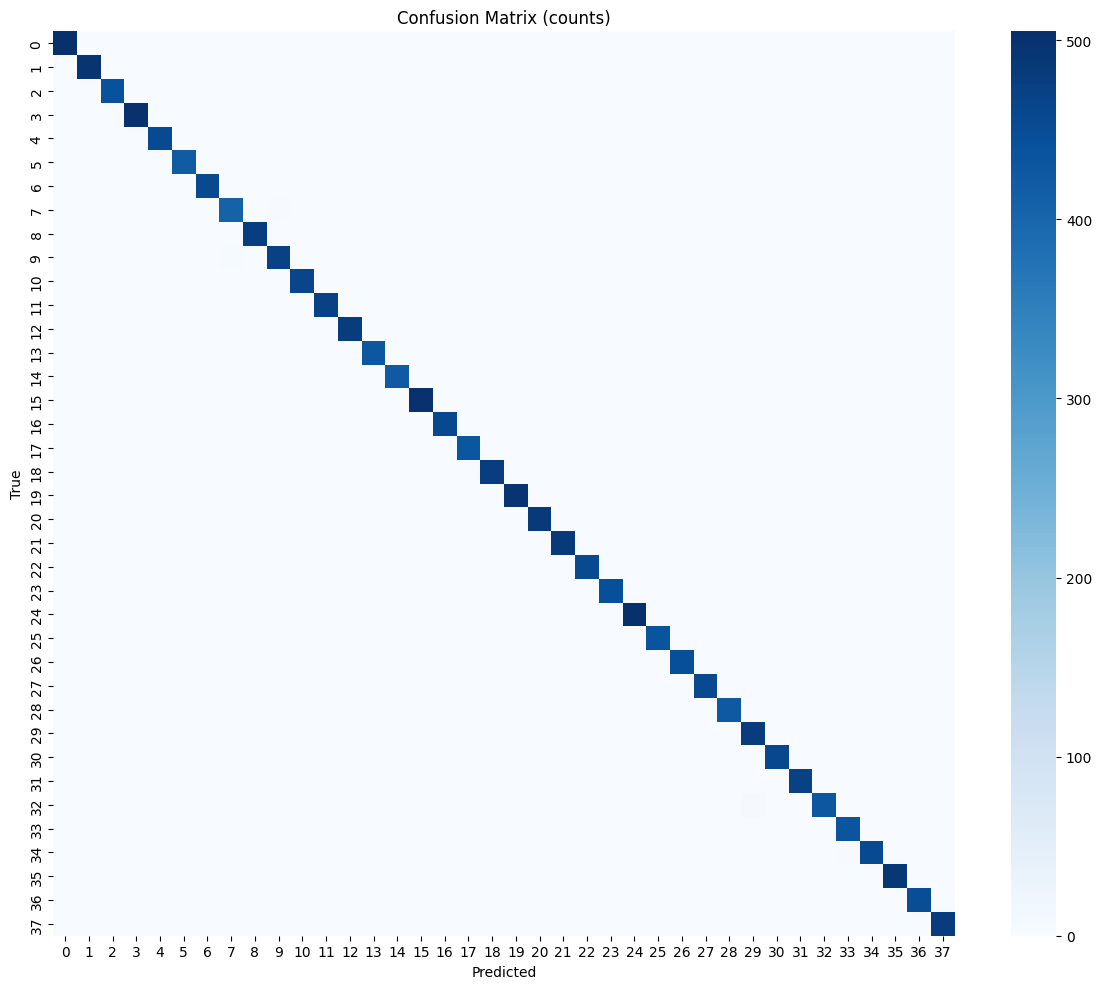

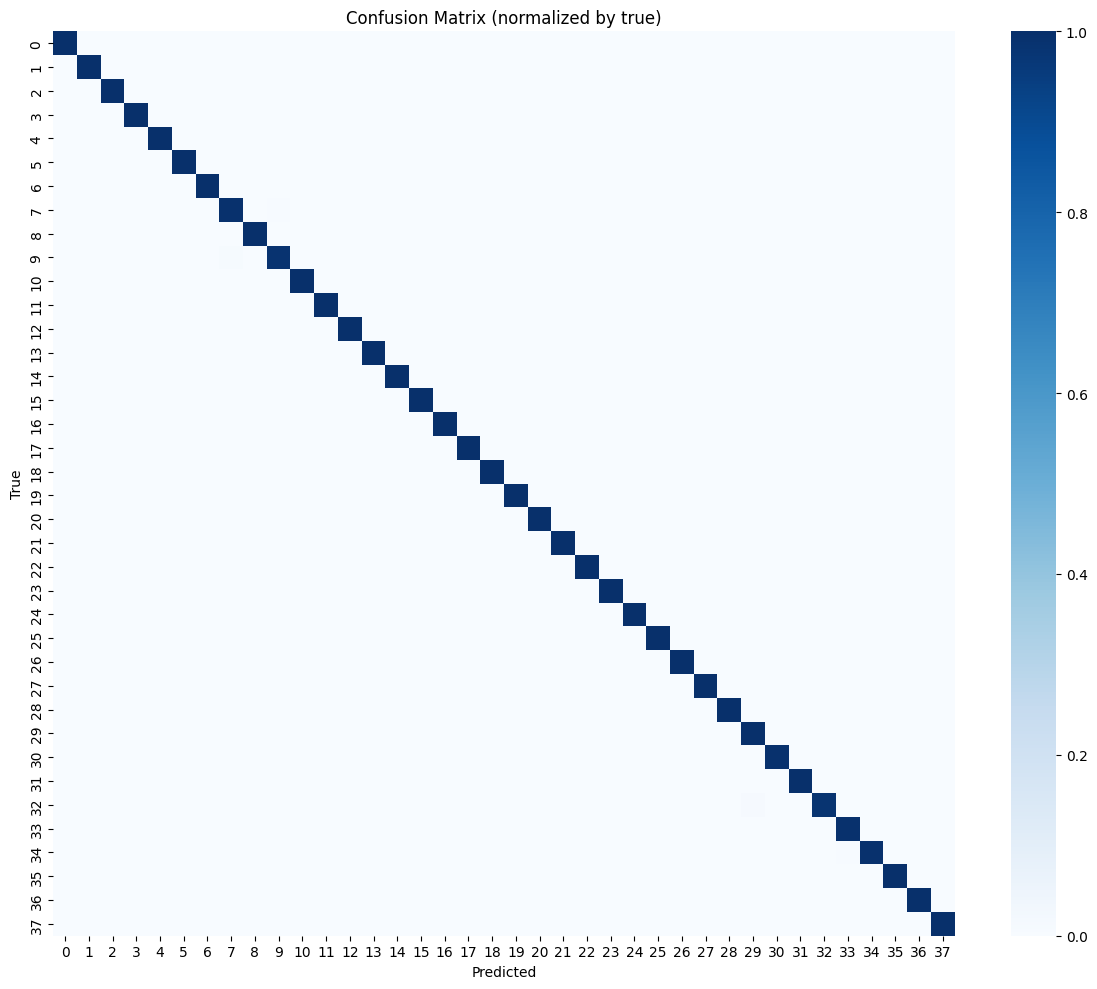

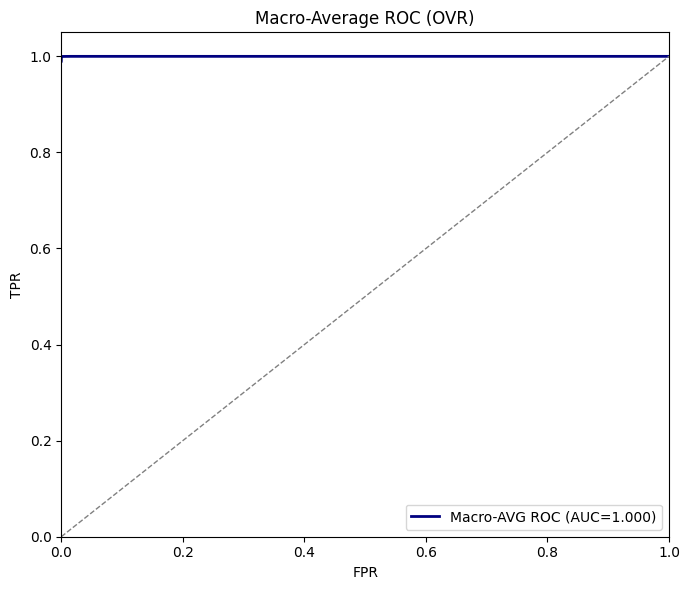

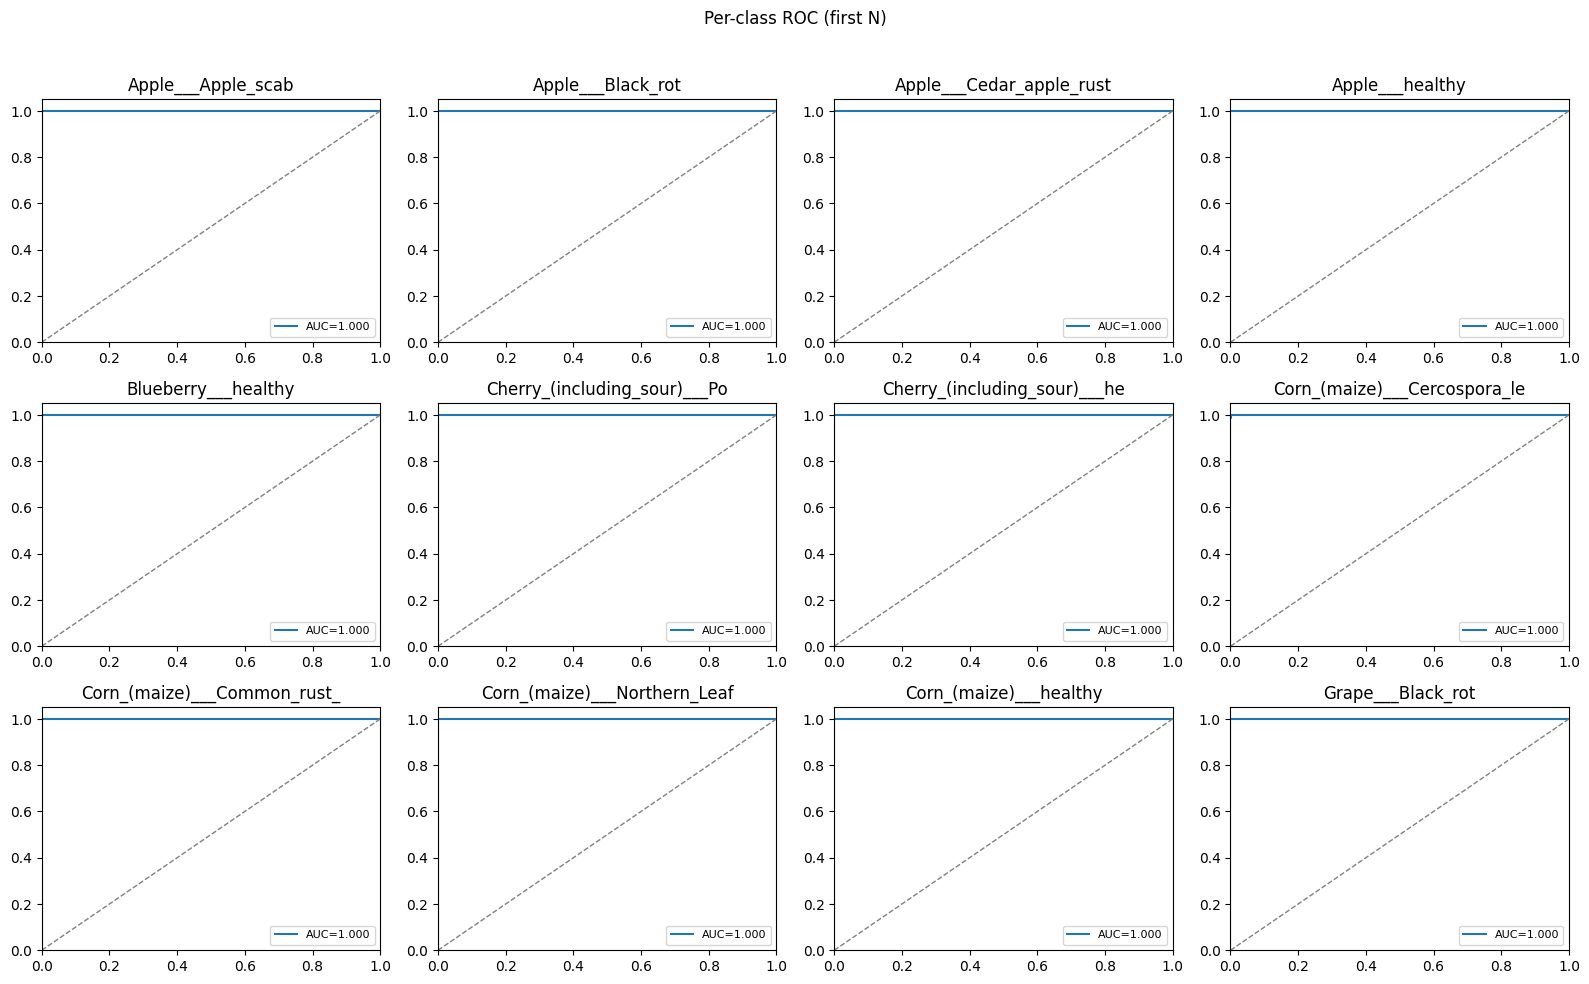

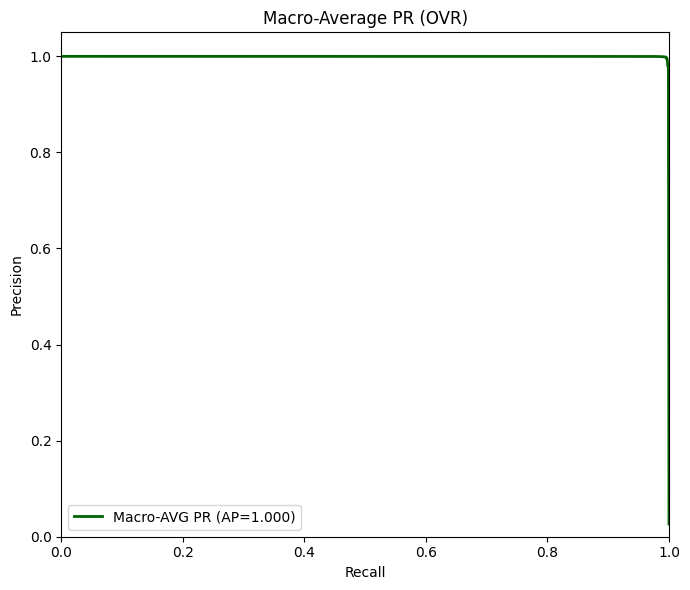

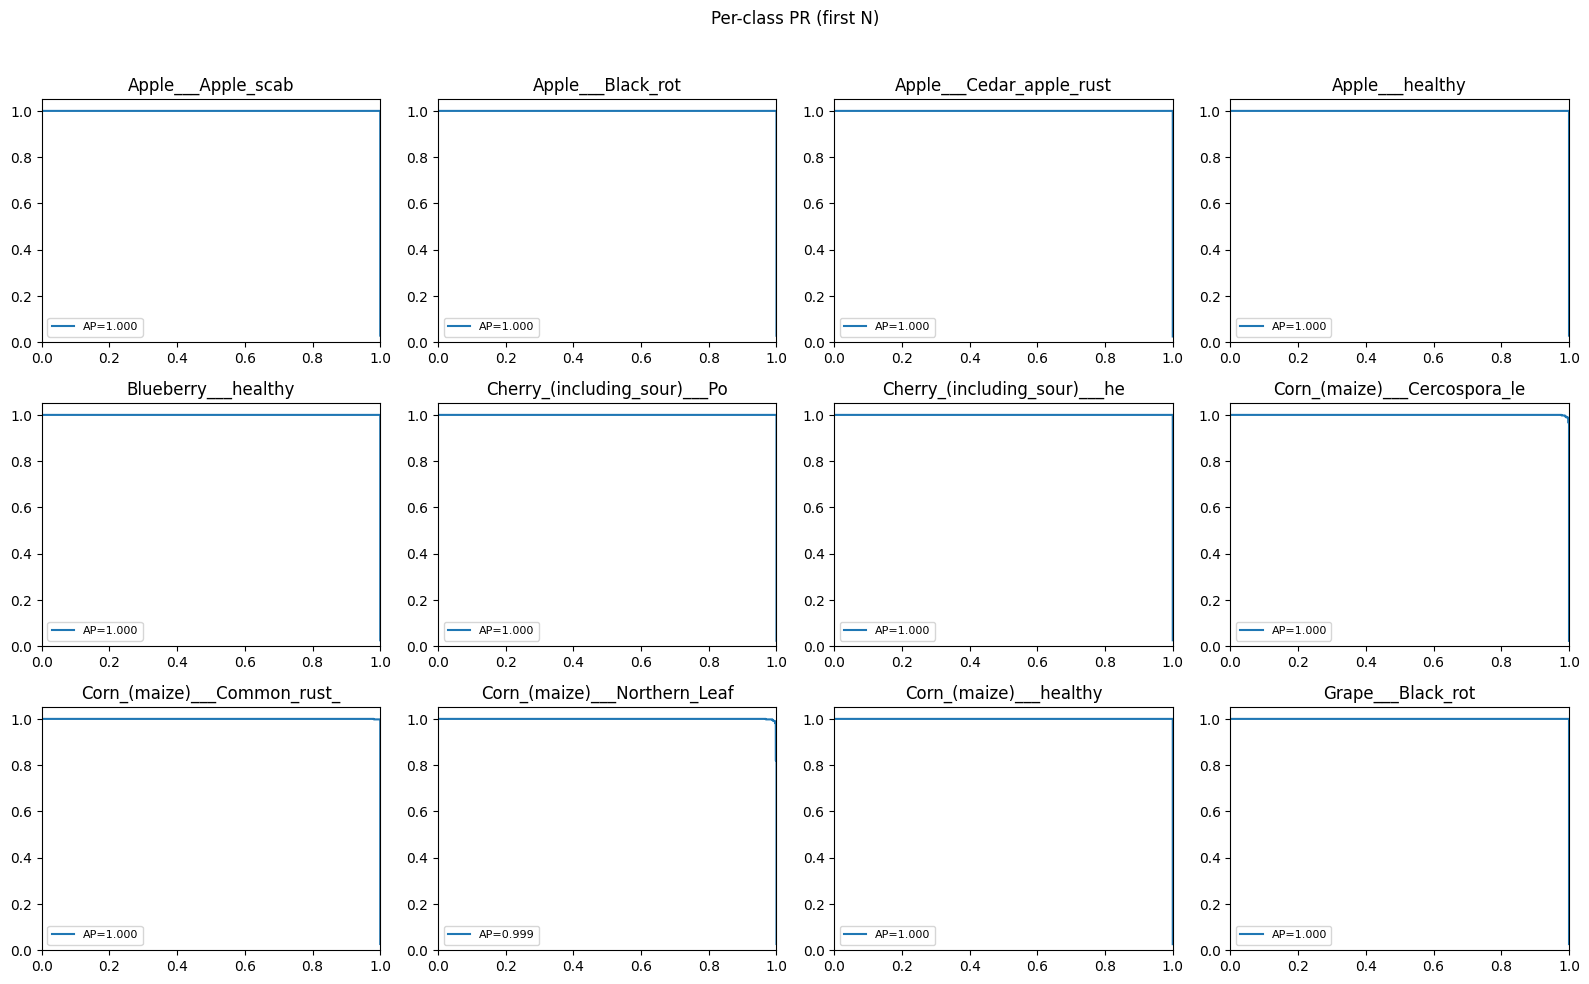

Saved all labeled-eval artifacts to: /content/plant_disease/outputs


In [13]:
# ===== UNIVERSAL ALL-IN-ONE REPORT (works with labeled or unlabeled test) =====
import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

# ---- Safe imports for metrics ----
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve,
    confusion_matrix, classification_report, top_k_accuracy_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# ---- Try to reuse notebook variables, otherwise set sane fallbacks ----
device = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
cfg = globals().get("cfg", None)
assert cfg is not None, "cfg not found. Please run the config cell before this report."

OUT_DIR = globals().get("OUT_DIR", str(Path.cwd() / "outputs"))
os.makedirs(OUT_DIR, exist_ok=True)

def has_class_folders(p):
    p = Path(p)
    return p.exists() and any(d.is_dir() for d in p.glob("*"))

# Try to reuse transforms/wrapper; define minimal versions if missing
get_eval_transforms = globals().get("get_eval_transforms", None)
AlbuWrapper = globals().get("AlbuWrapper", None)
if get_eval_transforms is None or AlbuWrapper is None:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    def get_eval_transforms(cfg_local):
        return A.Compose([
            A.Resize(cfg_local.IMAGE_SIZE[0], cfg_local.IMAGE_SIZE[1]),
            A.Normalize(mean=cfg_local.NORMALIZE_MEAN, std=cfg_local.NORMALIZE_STD),
            ToTensorV2()
        ])
    class AlbuWrapper:
        def __init__(self, tfm): self.tfm = tfm
        def __call__(self, img):
            arr = np.array(img.convert("RGB"))
            return self.tfm(image=arr)["image"]

# Build or reuse a model; prefer current variable named 'model'
model = globals().get("model", None)
build_model = globals().get("build_model", None)
if model is None:
    assert build_model is not None, "model and build_model not found. Please run the model cell first."
    model = build_model(cfg, arch="tf_efficientnet_b3_ns")
model = model.to(device).eval()

# Optional: resume best checkpoint if present
load_checkpoint = globals().get("load_checkpoint", None)
best_ckpt = f"{cfg.CKPT_DIR}/plant_best.pth"
if load_checkpoint is not None and os.path.exists(best_ckpt):
    try:
        _ = load_checkpoint(model, optimizer=None, scaler=None, path=best_ckpt, device=device)
        model.to(device).eval()
        print("Loaded best checkpoint:", best_ckpt)
    except Exception as e:
        print("Best checkpoint load failed:", e)

# Decide evaluation source
eval_dir = cfg.TEST_DIR if has_class_folders(cfg.TEST_DIR) else cfg.VAL_DIR if has_class_folders(cfg.VAL_DIR) else None
flat_test_dir = None
if eval_dir is None:
    # If neither has class folders, try to use TEST_DIR as a flat unlabeled folder
    if Path(cfg.TEST_DIR).exists():
        flat_test_dir = cfg.TEST_DIR
    else:
        raise RuntimeError("No labeled split found and TEST_DIR does not exist. Please create a labeled test/val split.")

print("Evaluation directory (labeled):", eval_dir)
print("Flat unlabeled test directory  :", flat_test_dir)

# ---- Data loaders ----
def make_labeled_loader(cfg_local, root):
    tfm = get_eval_transforms(cfg_local)
    ds = ImageFolder(root, transform=AlbuWrapper(tfm))
    dl = DataLoader(
        ds, batch_size=cfg_local.PHASES["main"]["batch"], shuffle=False,
        num_workers=getattr(cfg_local, "NUM_WORKERS", 0),
        persistent_workers=getattr(cfg_local, "PERSISTENT_WORKERS", False),
        pin_memory=getattr(cfg_local, "PIN_MEMORY", True)
    )
    return dl, ds

class FlatImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.files = [str(p) for p in self.root.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}]
        self.transform = transform
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        x = self.transform(img) if self.transform else img
        return x, self.files[i]  # return path for CSV

def make_flat_loader(cfg_local, root):
    tfm = get_eval_transforms(cfg_local)
    ds = FlatImageDataset(root, transform=AlbuWrapper(tfm))
    dl = DataLoader(
        ds, batch_size=cfg_local.PHASES["main"]["batch"], shuffle=False,
        num_workers=getattr(cfg_local, "NUM_WORKERS", 0),
        persistent_workers=getattr(cfg_local, "PERSISTENT_WORKERS", False),
        pin_memory=getattr(cfg_local, "PIN_MEMORY", True)
    )
    return dl, ds

@torch.no_grad()
def prob_tta(model, xb):
    p1 = torch.softmax(model(xb), dim=1)
    p2 = torch.softmax(model(torch.flip(xb, dims=[3])), dim=1)
    return ((p1+p2)/2)

# ========================== EVALUATION ==========================
if eval_dir is not None:
    # Labeled evaluation (full metrics)
    loader, ds = make_labeled_loader(cfg, eval_dir)
    class_names = ds.classes
    file_paths = [fp for (fp, _) in ds.samples]

    y_true, y_prob_all = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            prob = prob_tta(model, xb).detach().cpu().numpy()
        y_prob_all.append(prob)
        y_true.extend(yb.numpy().tolist())
    y_true = np.array(y_true)
    p = np.concatenate(y_prob_all, axis=0)
    y_pred = np.argmax(p, axis=1)
    conf = p.max(axis=1)

    # Overall metrics
    acc = accuracy_score(y_true, y_pred)
    top5 = top_k_accuracy_score(y_true, p, k=min(5, cfg.NUM_CLASSES), labels=np.arange(cfg.NUM_CLASSES)) if cfg.NUM_CLASSES >= 2 else np.nan
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

    try:
        y_true_bin = label_binarize(y_true, classes=list(range(cfg.NUM_CLASSES)))
        auc_macro = roc_auc_score(y_true_bin, p, average="macro", multi_class="ovr")
        auc_weighted = roc_auc_score(y_true_bin, p, average="weighted", multi_class="ovr")
    except Exception:
        y_true_bin = None
        auc_macro, auc_weighted = float("nan"), float("nan")

    print(f"ACC {acc:.4f} | TOP-5 {top5:.4f} | F1 macro {f1_macro:.4f} | AUC macro {auc_macro:.4f}")

    # Reports/CSVs
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    per_prec, per_rec, per_f1, per_support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=np.arange(cfg.NUM_CLASSES), zero_division=0
    )
    per_class_df = pd.DataFrame({
        "class": class_names, "precision": per_prec, "recall": per_rec, "f1": per_f1, "support": per_support
    }).sort_values("f1", ascending=True)
    per_class_df.to_csv(str(Path(OUT_DIR)/"per_class_metrics.csv"), index=False)

    per_image_df = pd.DataFrame({
        "file": file_paths,
        "true_idx": y_true, "true_name": [class_names[i] for i in y_true],
        "pred_idx": y_pred, "pred_name": [class_names[i] for i in y_pred],
        "confidence": conf, "correct": (y_true == y_pred)
    })
    per_image_df.to_csv(str(Path(OUT_DIR)/"per_image_predictions.csv"), index=False)

    # Confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(cfg.NUM_CLASSES))
    plt.figure(figsize=(12,10)); sns.heatmap(cm, cmap="Blues", cbar=True)
    plt.title("Confusion Matrix (counts)"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"confusion_matrix_counts.png"), dpi=150); plt.show()

    with np.errstate(all='ignore'):
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(12,10)); sns.heatmap(cm_norm, cmap="Blues", vmin=0, vmax=1, cbar=True)
    plt.title("Confusion Matrix (normalized by true)"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"confusion_matrix_normalized.png"), dpi=150); plt.show()

    # Most confused class pairs
    mc = cm.copy(); np.fill_diagonal(mc, 0)
    pairs = [(class_names[i], class_names[j], int(mc[i, j]))
             for i in range(cfg.NUM_CLASSES) for j in range(cfg.NUM_CLASSES) if i!=j and mc[i, j]>0]
    pd.DataFrame(pairs, columns=["true_class","pred_class","count"]).sort_values("count", ascending=False)\
      .to_csv(str(Path(OUT_DIR)/"most_confused_pairs.csv"), index=False)

    # ROC macro + per-class (grid)
    try:
        if y_true_bin is None: raise RuntimeError("No binarized labels")
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(cfg.NUM_CLASSES):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], p[:, i])
            roc_auc[i] = roc_auc_score(y_true_bin[:, i], p[:, i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(cfg.NUM_CLASSES)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(cfg.NUM_CLASSES):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= cfg.NUM_CLASSES

        plt.figure(figsize=(7,6))
        plt.plot(all_fpr, mean_tpr, color="navy", lw=2, label=f"Macro-AVG ROC (AUC={auc_macro:.3f})")
        plt.plot([0,1], [0,1], color="gray", lw=1, ls="--")
        plt.xlim([0,1]); plt.ylim([0,1.05])
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Macro-Average ROC (OVR)")
        plt.legend(loc="lower right")
        plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"roc_macro.png"), dpi=150); plt.show()

        N = min(12, cfg.NUM_CLASSES); n_cols=4; n_rows=math.ceil(N/n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows), squeeze=False)
        for idx in range(N):
            r,c = divmod(idx,n_cols); ax=axes[r][c]
            ax.plot(fpr[idx], tpr[idx], lw=1.5, label=f"AUC={roc_auc[idx]:.3f}")
            ax.plot([0,1],[0,1], color="gray", lw=1, ls="--")
            ax.set_title(class_names[idx][:28]); ax.set_xlim(0,1); ax.set_ylim(0,1.05)
            ax.legend(loc="lower right", fontsize=8)
        for k in range(N, n_rows*n_cols): axes[k//n_cols][k%n_cols].axis("off")
        fig.suptitle("Per-class ROC (first N)", y=1.02)
        plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"roc_per_class_grid.png"), dpi=150, bbox_inches="tight"); plt.show()
    except Exception as e:
        print("ROC plotting failed:", e)

    # PR macro + per-class (grid)
    try:
        if y_true_bin is None: raise RuntimeError("No binarized labels")
        prc, rec, ap = {}, {}, {}
        ap_macro = average_precision_score(y_true_bin, p, average="macro")
        for i in range(cfg.NUM_CLASSES):
            pr_i, rc_i, _ = precision_recall_curve(y_true_bin[:, i], p[:, i])
            prc[i], rec[i] = pr_i, rc_i
            ap[i] = average_precision_score(y_true_bin[:, i], p[:, i])

        recall_grid = np.linspace(0,1,1000)
        mean_prec = np.zeros_like(recall_grid)
        for i in range(cfg.NUM_CLASSES):
            mean_prec += np.interp(recall_grid, rec[i][::-1], prc[i][::-1])
        mean_prec /= cfg.NUM_CLASSES

        plt.figure(figsize=(7,6))
        plt.plot(recall_grid, mean_prec, color="darkgreen", lw=2, label=f"Macro-AVG PR (AP={ap_macro:.3f})")
        plt.xlim([0,1]); plt.ylim([0,1.05])
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Macro-Average PR (OVR)")
        plt.legend(loc="lower left")
        plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"pr_macro.png"), dpi=150); plt.show()

        N = min(12, cfg.NUM_CLASSES); n_cols=4; n_rows=math.ceil(N/n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows), squeeze=False)
        for idx in range(N):
            r,c = divmod(idx,n_cols); ax=axes[r][c]
            ax.plot(rec[idx], prc[idx], lw=1.5, label=f"AP={ap[idx]:.3f}")
            ax.set_title(class_names[idx][:28]); ax.set_xlim(0,1); ax.set_ylim(0,1.05)
            ax.legend(loc="lower left", fontsize=8)
        for k in range(N, n_rows*n_cols): axes[k//n_cols][k%n_cols].axis("off")
        fig.suptitle("Per-class PR (first N)", y=1.02)
        plt.tight_layout(); plt.savefig(str(Path(OUT_DIR)/"pr_per_class_grid.png"), dpi=150, bbox_inches="tight"); plt.show()
    except Exception as e:
        print("PR plotting failed:", e)

    # Summaries
    summary_txt = f"""
ACC {acc:.4f} | TOP-5 {top5:.4f} | Precision macro {prec_macro:.4f} | Recall macro {rec_macro:.4f} | F1 macro {f1_macro:.4f}
AUC macro {auc_macro:.4f} | weighted {auc_weighted:.4f}
Artifacts saved in {OUT_DIR}
"""
    with open(str(Path(OUT_DIR)/"evaluation_summary.txt"), "w") as f:
        f.write(summary_txt + "\nClassification report\n---------------------\n" + report)
    json.dump({
        "accuracy": float(acc),
        "top5": None if np.isnan(top5) else float(top5),
        "precision_macro": float(prec_macro),
        "recall_macro": float(rec_macro),
        "f1_macro": float(f1_macro),
        "auc_macro": None if np.isnan(auc_macro) else float(auc_macro),
        "auc_weighted": None if np.isnan(auc_weighted) else float(auc_weighted),
        "num_classes": int(cfg.NUM_CLASSES),
        "num_samples": int(len(y_true)),
        "evaluated_dir": eval_dir,
        "artifacts_dir": OUT_DIR,
    }, open(str(Path(OUT_DIR)/"evaluation_summary.json"), "w"), indent=2)

    print("Saved all labeled-eval artifacts to:", OUT_DIR)

else:
    # Unlabeled flat evaluation: predictions CSV + top-k per image
    loader, ds = make_flat_loader(cfg, flat_test_dir)
    class_names = [d.name for d in Path(cfg.TRAIN_DIR).glob("*") if d.is_dir()]
    file_paths, probs = [], []
    for xb, paths in loader:
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            prob = prob_tta(model, xb).detach().cpu().numpy()
        probs.append(prob); file_paths.extend(paths)
    p = np.concatenate(probs, axis=0)
    top1 = np.argmax(p, axis=1)
    conf = p.max(axis=1)

    # Build top-5 columns
    topk = min(5, p.shape[1])
    top5_idx = np.argsort(-p, axis=1)[:, :topk]
    top5_names = [[class_names[i] for i in row] for row in top5_idx]
    top5_scores = [p[i, top5_idx[i]].tolist() for i in range(len(file_paths))]

    df = pd.DataFrame({
        "file": file_paths,
        "pred_idx": top1,
        "pred_name": [class_names[i] for i in top1],
        "confidence": conf,
        "topk_idx": top5_idx.tolist(),
        "topk_name": top5_names,
        "topk_scores": top5_scores,
    })
    out_csv = str(Path(OUT_DIR)/"unlabeled_predictions.csv")
    df.to_csv(out_csv, index=False)
    print("Saved unlabeled predictions ->", out_csv)
    print("No confusion matrix/ROC/PR without ground-truth labels.")

In [14]:
import os, random, shutil
from pathlib import Path

random.seed(42)

VAL_DIR = cfg.VAL_DIR
TEST_DIR = cfg.TEST_DIR
SHARE = 0.2  # portion of each class in val to copy into test (e.g., 0.2 = 20%)

assert Path(VAL_DIR).exists(), f"VAL_DIR not found: {VAL_DIR}"
Path(TEST_DIR).mkdir(parents=True, exist_ok=True)

def list_images(dir_):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp")
    return [p for p in Path(dir_).glob("*") if p.suffix.lower() in exts]

moved = 0
for cls_dir in [d for d in Path(VAL_DIR).glob("*") if d.is_dir()]:
    imgs = list(cls_dir.glob("*"))
    imgs = [p for p in imgs if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}]
    if not imgs:
        continue
    random.shuffle(imgs)
    k = max(1, int(SHARE * len(imgs)))
    dst_cls = Path(TEST_DIR) / cls_dir.name
    dst_cls.mkdir(parents=True, exist_ok=True)
    # COPY (not move) to keep val intact
    for p in imgs[:k]:
        shutil.copy2(str(p), str(dst_cls / p.name))
    moved += k

print(f"Copied {moved} images into TEST_DIR: {TEST_DIR}")

# Quick counts
def count_imgs(root):
    total = 0
    for cd in [d for d in Path(root).glob("*") if d.is_dir()]:
        n = len([p for p in cd.glob("*") if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'}])
        print(f"{cd.name}: {n}")
        total += n
    print("Total:", total)

print("\nVAL counts:")
count_imgs(VAL_DIR)
print("\nTEST counts:")
count_imgs(TEST_DIR)

Copied 3503 images into TEST_DIR: /content/plant_disease/data/test

VAL counts:
Tomato___Leaf_Mold: 470
Soybean___healthy: 505
Squash___Powdery_mildew: 434
Potato___Early_blight: 485
Potato___Late_blight: 485
Grape___Esca_(Black_Measles): 480
Orange___Haunglongbing_(Citrus_greening): 503
Pepper,_bell___healthy: 497
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 410
Apple___Cedar_apple_rust: 440
Apple___healthy: 502
Blueberry___healthy: 454
Strawberry___healthy: 456
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 430
Potato___healthy: 456
Corn_(maize)___Northern_Leaf_Blight: 477
Pepper,_bell___Bacterial_spot: 478
Cherry_(including_sour)___Powdery_mildew: 421
Cherry_(including_sour)___healthy: 456
Corn_(maize)___Common_rust_: 477
Grape___Black_rot: 472
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 490
Tomato___Early_blight: 480
Corn_(maize)___healthy: 465
Apple___Apple_scab: 504
Tomato___Septoria_leaf_spot: 436
Peach___healthy: 432
Tomato___Bacterial_spot: 425
Apple___Black_rot: 497
Tomato___